In [1]:
# format the book
%matplotlib inline
import sys
from __future__ import division, print_function
import sys
sys.path.insert(0,'../code')
import book_format
book_format.load_style('../code')

# Estimation

## The dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided die,
an 8-sided die, a 12-sided die, and a 20-sided die. If you have ever
played *Dungeons & Dragons*, you know what I am talking
about.

Suppose I select a die from the box at random, roll it, and get a 6.
What is the probability that I rolled each die?

Let me suggest a three-step strategy for approaching a problem like
this.

1.  Choose a representation for the hypotheses.

2.  Choose a representation for the data.

3.  Write the likelihood function.

In previous examples I used strings to represent hypotheses and data,
but for the die problem I’ll use numbers. Specifically, I’ll use the
integers 4, 6, 8, 12, and 20 to represent hypotheses:

In [3]:
from dice import Dice

suite = Dice([4, 6, 8, 12, 20])

And integers from 1 to 20 for the data. These representations make it
easy to write the likelihood function:

```python
class Dice(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
```

Here’s how `Likelihood` works. If `hypo<data`, that means the roll is
greater than the number of sides on the die. That can’t happen, so the
likelihood is 0.

Otherwise the question is, “Given that there are `hypo`
sides, what is the chance of rolling `data`?” The answer is
`1/hypo`, regardless of `data`.

Here is the statement that does the update (if I roll a 6):

In [4]:
suite.Update(6)

0.08500000000000002

And here is the posterior distribution:

In [5]:
suite.Print()

4 0.0
6 0.3921568627450979
8 0.2941176470588235
12 0.19607843137254896
20 0.11764705882352941


After we roll a 6, the probability for the 4-sided die is 0. The most
likely alternative is the 6-sided die, but there is still almost a 12%
chance for the 20-sided die.

What if we roll a few more times and get 6, 8, 7, 7, 5, and 4?

In [7]:
for roll in [6, 8, 7, 7, 5, 4]:
    suite.Update(roll)

With this data the 6-sided die is eliminated, and the 8-sided die seems
quite likely. Here are the results:

In [8]:
suite.Print()

4 0.0
6 0.0
8 0.9432484536722127
12 0.055206128061290875
20 0.001545418266496554


Now the probability is 94% that we are rolling the 8-sided die, and less
than 1% for the 20-sided die.

The dice problem is based on an example I saw in Sanjoy Mahajan’s class
on Bayesian inference. You can download the code in this section from
<http://thinkbayes.com/dice.py>. For more information see
Section [download].

## The locomotive problem

I found the locomotive problem in Frederick Mosteller’s, *Fifty
Challenging Problems in Probability with Solutions* (Dover,
1987):

> “A railroad numbers its locomotives in order 1..N. One day you see a
> locomotive with the number 60. Estimate how many locomotives the
> railroad has.”

Based on this observation, we know the railroad has 60 or more
locomotives. But how many more? To apply Bayesian reasoning, we can
break this problem into two steps:

1.  What did we know about $N$ before we saw the data?

2.  For any given value of $N$, what is the likelihood of seeing the
    data (a locomotive with number 60)?

The answer to the first question is the prior. The answer to the second
is the likelihood.

![Posterior distribution for the locomotive problem, based on a uniform
prior.](figs/train1.pdf)

[fig.train1]

We don’t have much basis to choose a prior, but we can start with
something simple and then consider alternatives. Let’s assume that $N$
is equally likely to be any value from 1 to 1000.

In [9]:
hypos = range(1, 1001)

Now all we need is a likelihood function. In a hypothetical fleet of $N$
locomotives, what is the probability that we would see number 60? If we
assume that there is only one train-operating company (or only one we
care about) and that we are equally likely to see any of its
locomotives, then the chance of seeing any particular locomotive is
$1/N$.

Here’s the likelihood function:

```python
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
```

This might look familiar; the likelihood functions for the locomotive
problem and the dice problem are identical.

Here’s the update:

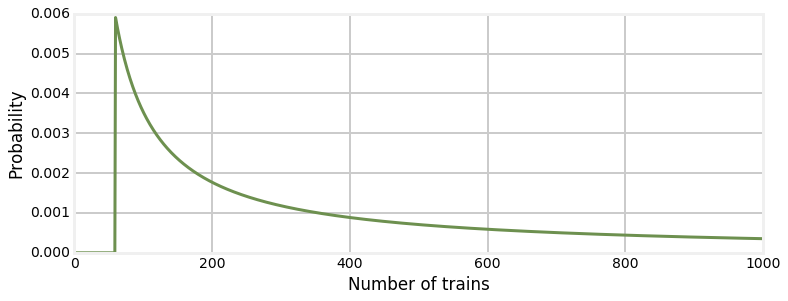

In [31]:
from train import Train
import matplotlib.pyplot as plt

suite = Train(hypos)
suite.Update(60)

hs, ps = [], []
for hypo, prob in sorted(suite.Items()):
    hs.append(hypo)
    ps.append(prob)
    
plt.plot(hs, ps)
plt.xlabel('Number of trains')
plt.ylabel('Probability');

There are too many hypotheses to print, so I plotted the results in
Figure [fig.train1]. Not surprisingly, all values of $N$ below 60 have
been eliminated.

The most likely value, if you had to guess, is 60. That might not seem
like a very good guess; after all, what are the chances that you just
happened to see the train with the highest number? Nevertheless, if you
want to maximize the chance of getting the answer exactly right, you
should guess 60.

But maybe that’s not the right goal. An alternative is to compute the
mean of the posterior distribution:

In [22]:
def Mean(suite):
    total = 0
    for hypo, prob in suite.Items():
        total += hypo * prob
    return total

print(Mean(suite))

333.41989326371095


Or you could use the very similar method provided by `Pmf`:

In [23]:
print(suite.Mean())

333.41989326371095


The mean of the posterior is 333, so that might be a good guess if you
wanted to minimize error. If you played this guessing game over and
over, using the mean of the posterior as your estimate would minimize
the mean squared error over the long run (see
<http://en.wikipedia.org/wiki/Minimum_mean_square_error>).

You can download this example from <http://thinkbayes.com/train.py>. For
more information see Section [download].

## What about that prior?

To make any progress on the locomotive problem we had to make
assumptions, and some of them were pretty arbitrary. In particular, we
chose a uniform prior from 1 to 1000, without much justification for
choosing 1000, or for choosing a uniform distribution.

It is not crazy to believe that a railroad company might operate 1000
locomotives, but a reasonable person might guess more or fewer. So we
might wonder whether the posterior distribution is sensitive to these
assumptions. With so little data—only one observation—it probably is.

Recall that with a uniform prior from 1 to 1000, the mean of the
posterior is 333. With an upper bound of 500, we get a posterior mean of
207, and with an upper bound of 2000, the posterior mean is 552.

So that’s bad. There are two ways to proceed:

-   Get more data.

-   Get more background information.

With more data, posterior distributions based on different priors tend
to converge. For example, suppose that in addition to train 60 we also
see trains 30 and 90. We can update the distribution like this:

In [27]:
for data in [60, 30, 90]:
    suite.Update(data)

With these data, the means of the posteriors are

      ------- -----------
      Upper   Posterior
      Bound   Mean
      500     152
      1000    164
      2000    171
      ------- -----------

So the differences are smaller.

## An alternative prior

![Posterior distribution based on a power law prior, compared to a
uniform prior.](figs/train4.pdf)

[fig.train4]

If more data are not available, another option is to improve the priors
by gathering more background information. It is probably not reasonable
to assume that a train-operating company with 1000 locomotives is just
as likely as a company with only 1.

With some effort, we could probably find a list of companies that
operate locomotives in the area of observation. Or we could interview an
expert in rail shipping to gather information about the typical size of
companies.

But even without getting into the specifics of railroad economics, we
can make some educated guesses. In most fields, there are many small
companies, fewer medium-sized companies, and only one or two very large
companies. In fact, the distribution of company sizes tends to follow a
power law, as Robert Axtell reports in *Science* (see
<http://www.sciencemag.org/content/293/5536/1818.full.pdf>).

This law suggests that if there are 1000 companies with fewer than 10
locomotives, there might be 100 companies with 100 locomotives, 10
companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a
given size is inversely proportional to size, or

$${\mathrm{PMF}}(x) \propto \left( \frac{1}{x} \right)^{\alpha}$$ 

where
${\mathrm{PMF}}(x)$ is the probability mass function of $x$ and $\alpha$
is a parameter that is often near 1.

We can construct a power law prior like this:

```python
class Train(Dice):

    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
```

And here’s the code that constructs the prior:

In [35]:
from train3 import Train

hypos = range(1, 1001)
suite = Train(hypos)

Again, the upper bound is arbitrary, but with a power law prior, the
posterior is less sensitive to this choice.

Figure [fig.train4] shows the new posterior based on the power law,
compared to the posterior based on the uniform prior. Using the
background information represented in the power law prior, we can all
but eliminate values of $N$ greater than 700.

If we start with this prior and observe trains 30, 60, and 90, the means
of the posteriors are

      ------- -----------
      Upper   Posterior
      Bound   Mean
      500     131
      1000    133
      2000    134
      ------- -----------

Now the differences are much smaller. In fact, with an arbitrarily large
upper bound, the mean converges on 134.

So the power law prior is more realistic, because it is based on general
information about the size of companies, and it behaves better in
practice.

You can download the examples in this section from
<http://thinkbayes.com/train3.py>. For more information see
Section [download].

## Credible intervals

Once you have computed a posterior distribution, it is often useful to
summarize the results with a single point estimate or an interval. For
point estimates it is common to use the mean, median, or the value with
maximum likelihood.

For intervals we usually report two values computed so that there is a
90% chance that the unknown value falls between them (or any other
probability). These values define a **credible interval**.

A simple way to compute a credible interval is to add up the
probabilities in the posterior distribution and record the values that
correspond to probabilities 5% and 95%. In other words, the 5th and 95th
percentiles.

`thinkbayes` provides a function that computes percentiles:

```python
def Percentile(pmf, percentage):
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val    
```

And here’s the code that uses it:

In [36]:
from thinkbayes import Percentile

interval = Percentile(suite, 5), Percentile(suite, 95)
print(interval)

(50, 950)


For the previous example—the locomotive problem with a power law prior
and three trains—the 90% credible interval is $(91, 243)$. The width of
this range suggests, correctly, that we are still quite uncertain about
how many locomotives there are.

## Cumulative distribution functions

In the previous section we computed percentiles by iterating through the
values and probabilities in a Pmf. If we need to compute more than a few
percentiles, it is more efficient to use a cumulative distribution
function, or Cdf.

Cdfs and Pmfs are equivalent in the sense that they contain the same
information about the distribution, and you can always convert from one
to the other. The advantage of the Cdf is that you can compute
percentiles more efficiently.

`thinkbayes` provides a `Cdf` class that
represents a cumulative distribution function. `Pmf` provides
a method that makes the corresponding Cdf:

In [37]:
cdf = suite.MakeCdf()

And `Cdf` provides a function named `Percentile`

In [39]:
interval = cdf.Percentile(5), cdf.Percentile(95)
print(interval)

(50, 950)


Converting from a Pmf to a Cdf takes time proportional to the number of
values, `len(pmf)`. The Cdf stores the values and
probabilities in sorted lists, so looking up a probability to get the
corresponding value takes “log time”: that is, time proportional to the
logarithm of the number of values. Looking up a value to get the
corresponding probability is also logarithmic, so Cdfs are efficient for
many calculations.

The examples in this section are in <http://thinkbayes.com/train3.py>.
For more information see Section [download].

## The German tank problem

During World War II, the Economic Warfare Division of the American
Embassy in London used statistical analysis to estimate German
production of tanks and other equipment.[^2]

The Western Allies had captured log books, inventories, and repair
records that included chassis and engine serial numbers for individual
tanks.

Analysis of these records indicated that serial numbers were allocated
by manufacturer and tank type in blocks of 100 numbers, that numbers in
each block were used sequentially, and that not all numbers in each
block were used. So the problem of estimating German tank production
could be reduced, within each block of 100 numbers, to a form of the
locomotive problem.

Based on this insight, American and British analysts produced estimates
substantially lower than estimates from other forms of intelligence. And
after the war, records indicated that they were substantially more
accurate.

They performed similar analyses for tires, trucks, rockets, and other
equipment, yielding accurate and actionable economic intelligence.

The German tank problem is historically interesting; it is also a nice
example of real-world application of statistical estimation. So far many
of the examples in this book have been toy problems, but it will not be
long before we start solving real problems. I think it is an advantage
of Bayesian analysis, especially with the computational approach we are
taking, that it provides such a short path from a basic introduction to
the research frontier.

## Discussion

Among Bayesians, there are two approaches to choosing prior
distributions. Some recommend choosing the prior that best represents
background information about the problem; in that case the prior is said
to be **informative**. The problem with using an
informative prior is that people might use different background
information (or interpret it differently). So informative priors often
seem subjective.

The alternative is a so-called **uninformative prior**,
which is intended to be as unrestricted as possible, in order to let the
data speak for themselves. In some cases you can identify a unique prior
that has some desirable property, like representing minimal prior
information about the estimated quantity.

Uninformative priors are appealing because they seem more objective. But
I am generally in favor of using informative priors. Why? First,
Bayesian analysis is always based on modeling decisions. Choosing the
prior is one of those decisions, but it is not the only one, and it
might not even be the most subjective. So even if an uninformative prior
is more objective, the entire analysis is still subjective.

Also, for most practical problems, you are likely to be in one of two
regimes: either you have a lot of data or not very much. If you have a
lot of data, the choice of the prior doesn’t matter very much;
informative and uninformative priors yield almost the same results.
We’ll see an example like this in the next chapter.

But if, as in the locomotive problem, you don’t have much data, using
relevant background information (like the power law distribution) makes
a big difference.

And if, as in the German tank problem, you have to make life-and-death
decisions based on your results, you should probably use all of the
information at your disposal, rather than maintaining the illusion of
objectivity by pretending to know less than you do.

## Exercises

To write a likelihood function for the locomotive problem, we had to
answer this question: “If the railroad has $N$ locomotives, what is the
probability that we see number 60?”

The answer depends on what sampling process we use when we observe the
locomotive. In this chapter, I resolved the ambiguity by specifying that
there is only one train-operating company (or only one that we care
about).

But suppose instead that there are many companies with different numbers
of trains. And suppose that you are equally likely to see any train
operated by any company. In that case, the likelihood function is
different because you are more likely to see a train operated by a large
company.

As an exercise, implement the likelihood function for this variation of
the locomotive problem, and compare the results.